# Exercise 2.4

Use the data and calculations from Exercise 1.7 and assume that the insurance company collects all the premiums at the beginning of the year. Consider a low-risk fixed 1-year interest rate of 5% and that the shareholders of the company expect a ROE (return on equity) of 12%. Assuming that deaths are uniformly distributed (probabilistically) throughout the year, using again 100,000 simulations of the portfolio, estimate quantiles 2.5%, 25%, 50% (median), 75%, and 97.5\% of the ROE, and the probability $\mathbb{P}(\text{ROE}\geq 12\%),$ under each of the following premium principles:
1. Expected value principle.
2. Variance principle.
3. Using formula from Exercise 2.3

## Upload and prepare data

In [100]:
using Distributions, Statistics, Plots, CSV, DataFrames

In [101]:
mort = DataFrame(CSV.File("mortality.csv")) # mortality table
policy = DataFrame(CSV.File("LIFEinsurance.csv")); # insurance policies

In [102]:
mort[[1,2,3,end-2,end-1,end], :]

Row,AGE,qx
,Int64,Float64
1,0,0.00115
2,1,0.00115
3,2,0.001155
4,108,0.866245
5,109,0.924875
6,110,1.0


In [103]:
policy[1:3, :]

Row,AGE,INSAMOUNT
,Int64,Float64
1,49,9.2
2,26,3.1
3,59,10.7


Theoretical mean and variance for total claims: $\mathbb{E}(S)$ and $\mathbb{V}(S).$ Add to DataFrame `policy` columns for $\mathbb{E}(X_j),$ $\mathbb{V}(X_j)$ and $\mathbb{D}(X_j)=\mathbb{E}(\max\{X_j - \mathbb{E}(X_j), 0\}).$

In [104]:
n = length(policy.AGE) # number of insurance policies
k = 1/10 # probability of accident given death
q = Dict(mort.AGE .=> mort.qx) # mapping age -> qx
policy.EX = zeros(n)
policy.VX = zeros(n)
policy.DX = zeros(n)
ES, VS = 0.0, 0.0
for j ∈ 1:n
    qj = q[policy.AGE[j]]
    cj = policy.INSAMOUNT[j]
    policy.EX[j] = (1 + k)*cj*qj
    ES += policy.EX[j]
    policy.VX[j] = qj*(1-qj)*((1+k)*cj)^2 + qj*(1-k)k*(cj^2)
    VS += policy.VX[j] # assuming independence
    policy.DX[j] = sum(max.((0, cj, 2cj) .- policy.EX[j], 0) .* (1 - qj, qj * (1 - k), qj * k))
end
println("E(S) = ", ES)
println("V(S) = ", VS)
policy[1:5, :]
size(policy)

E(S) = 345.3497998500011
V(S) = 4202.942121519234


(10000, 5)

In [105]:
policy[1:3, :]

Row,AGE,INSAMOUNT,EX,VX,DX
,Int64,Float64,Float64,Float64,Float64
1,49,9.2,0.039468,0.427567,0.0393141
2,26,3.1,0.00567765,0.0207686,0.0056682
3,59,10.7,0.0777997,0.97776,0.0772854


Approximate median and 99.5% Value at Risk for total claims: $\mathbb{M}(S)$ and $\text{VaR}_{0.995}(S)$

In [106]:
m = 100_000
n = length(policy.AGE) # number of insurance policies
S = zeros(m)
begin
    Death = zeros(Bool, m, n) 
    Accident = rand(Bernoulli(k), m, n)
    for j ∈ 1:n
        Death[:, j] = rand(Bernoulli(q[policy.AGE[j]]), m)
    end
    for i ∈ 1:m
        S[i] = sum(policy.INSAMOUNT .* Death[i, :] .* (1 .+ Accident[i, :]))
    end
end

In [107]:
Death = 0; Accident = 0; # release memory

In [108]:
MS = median(S)
VaR = quantile(S, 0.995)
println("M(S) = ", MS)
println("99.5% VaR = ", VaR)

M(S) = 342.7
99.5% VaR = 527.2


Solvency Capital Requirement, based on the expected value and the median: $\text{SCRe}(S)$ and $\text{SCRm}(S)$

In [109]:
SCRe = VaR - ES # based on expected value
SCRm = VaR - MS # based on the median
println("SCRe(S) = ", SCRe)
println("SCRm(S) = ", SCRm)

SCRe(S) = 181.85020014999895
SCRm(S) = 184.50000000000006


Risk Margin, based on the expected value and the median: $\text{RMe}(S)$ and $\text{RMm}(S)$

In [110]:
r = 0.12 # shareholders' return rate (ROE)
i = 0.05; # low-risk return rate
RMe = (r - i) * SCRe # based on expected value
RMm = (r - i) * SCRm # based on the median
println("RMe(S) = ", RMe)
println("RMm(S) = ", RMm)

RMe(S) = 12.729514010499926
RMm(S) = 12.915000000000003


## Premiums

**Expected value principle**

In [111]:
θE = RMe / ES

0.03685976947439625

In [112]:
policy.PErisk = policy.EX
policy.PEmargin = θE .* policy.EX
policy.PE = policy.PErisk .+ policy.PEmargin
size(policy)

(10000, 8)

In [113]:
policy[1:3, :]

Row,AGE,INSAMOUNT,EX,VX,DX,PErisk,PEmargin,PE
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,49,9.2,0.039468,0.427567,0.0393141,0.039468,0.00145478,0.0409228
2,26,3.1,0.00567765,0.0207686,0.0056682,0.00567765,0.000209277,0.00588693
3,59,10.7,0.0777997,0.97776,0.0772854,0.0777997,0.00286768,0.0806674


In [114]:
sum(policy.PE), ES + RMe # checking the sum of total premiums

(358.07931386049995, 358.07931386050103)

**Variance principle** 

In [115]:
θV = RMe / VS

0.003028715038763988

In [116]:
policy.PVrisk = policy.EX
policy.PVmargin = θV .* policy.VX
policy.PV = policy.PVrisk .+ policy.PVmargin
size(policy)

(10000, 11)

In [117]:
policy[1:3, 6:11]

Row,PErisk,PEmargin,PE,PVrisk,PVmargin,PV
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.039468,0.00145478,0.0409228,0.039468,0.00129498,0.040763
2,0.00567765,0.000209277,0.00588693,0.00567765,6.29022e-5,0.00574055
3,0.0777997,0.00286768,0.0806674,0.0777997,0.00296136,0.0807611


In [118]:
sum(policy.PV), ES + RMe # checking the sum of total premiums

(358.0793138605, 358.07931386050103)

Comparing against the expected value principle:

In [119]:
PEPV = policy.PE ./ policy.PV
quantile(PEPV, [0.025, 0.5, 0.975])

3-element Vector{Float64}:
 0.98561991298423
 1.0080928559441542
 1.031697074360237

In [120]:
mean(PEPV)

1.0076333938223851

As expected, individual premiums based on the expected value principle are higher (on average and median) that those based in the variance principle, since the expected value principle is not consistent and loads the risk premium more than it should.

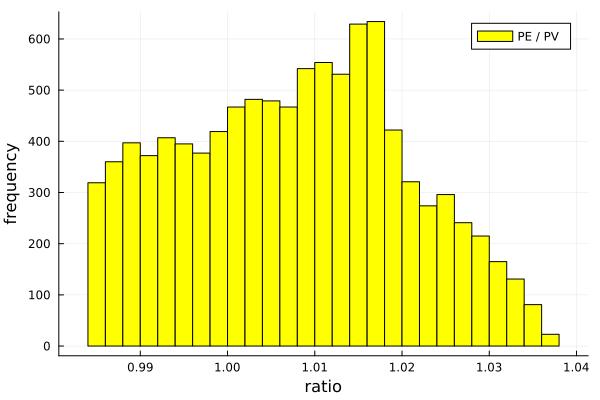

In [121]:
histogram(PEPV, label = "PE / PV", xlabel = "ratio", ylabel = "frequency", color = :yellow)

**Exercise 2.3 formula**

In [122]:
sD = sum(policy.DX)
policy.PDrisk = (MS / ES) .* policy.EX
policy.PDmargin = (RMm / sD) .* policy.DX
policy.PD = policy.PDrisk .+ policy.PDmargin
size(policy)

(10000, 14)

In [123]:
policy[1:3, 9:14]

Row,PVrisk,PVmargin,PV,PDrisk,PDmargin,PD
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.039468,0.00129498,0.040763,0.0391652,0.00147742,0.0406426
2,0.00567765,6.29022e-5,0.00574055,0.00563409,0.00021301,0.0058471
3,0.0777997,0.00296136,0.0807611,0.0772028,0.00290438,0.0801071


In [124]:
sum(policy.PD), MS + RMm # checking the sum of total premiums

(355.61499999999893, 355.615)

Comparing against the variance principle:

In [125]:
PDPV = policy.PD ./ policy.PV
quantile(PDPV, [0.025, 0.5, 0.975])

3-element Vector{Float64}:
 0.9788113480128529
 1.0012057193912658
 1.0247237071370785

In [126]:
mean(PDPV)

1.0007507825672755

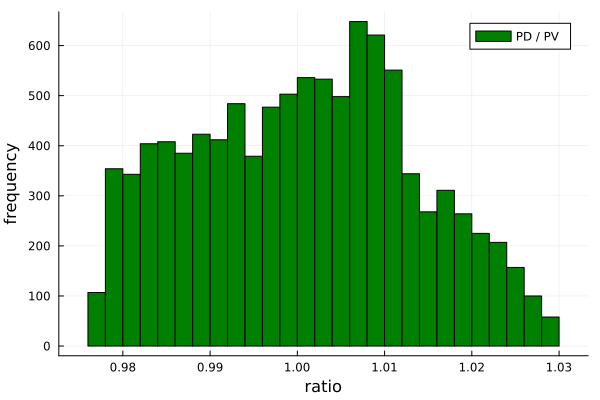

In [127]:
histogram(PDPV, label = "PD / PV", xlabel = "ratio", ylabel = "frequency", color = :green)

## Simulation

**Claims**

In [128]:
function simulateClaims() # from each insurance policy
    n = length(policy.AGE)
    k = 1/10 # probability of accident given death
    Death = zeros(n) 
    Accident = rand(Bernoulli(k), n)
    Claim = zeros(n)
    for j ∈ 1:n
        Death[j] = rand(Bernoulli(q[policy.AGE[j]]), 1)[1]
        Claim[j] = policy.INSAMOUNT[j] * Death[j] * (1 + Accident[j])
    end
    return Claim # vector of each policy claim (if any)
end

simulateClaims (generic function with 1 method)

In [129]:
ES, VaR, sum(simulateClaims()) # try several times just to see

(345.3497998500011, 527.2, 261.09999999999997)

**Accounting**

In [130]:
function simulateAcc(premiumPrinciple::String) 
    # "E" = expected value | "V" = variance | "D" = Exercise 2.3
    # Liabilities
    BEL = zeros(367); RM = zeros(367); L = zeros(367)
    # Assets: AR (reserves -> rate i), AF (free -> r)
    AR = zeros(367); AF = zeros(367); A = zeros(367) 
    # Capital
    SCR = zeros(367); K = zeros(367) 
    # [1] -> starting values | [2:366] -> 365 days of the year | [367] -> closing of the year
    if premiumPrinciple ∈ ["E", "V"]
        BEL[1] = ES; RM[1] = RMe; SCR[1] = SCRe
    elseif premiumPrinciple == "D"
        BEL[1] = MS; RM[1] = RMm; SCR[1] = SCRm
    else
        println("Unknown premium principle, try again!")
        return nothing
    end
    # starting Balance Sheet:
    L[1] = BEL[1] + RM[1]
    K[1] = SCR[1]
    AR[1] = L[1] + SCR[1]; AF[1] = 0; A[1] = AR[1] + AF[1]
    # claims of the year:
    claims = simulateClaims() # from each insurance policy
    idClaims = findall(a -> a > 0, claims) # policies with positive claims
    n = length(claims) # number of insurance policies in portfolio
    dayClaim = rand(DiscreteUniform(2, 366), n) # uniform distribution of claims during the year
    C = zeros(367) # to allocate total claims amount per day
    # equivalent daily rates:
    ii = (1 + i)^(1/365) - 1 # equivalent daily rate
    rr = (1 + r)^(1/365) - 1 # equivalent daily rate
    # simulate daily accounting:
    for d ∈ 2:366
        policies = findall(j -> j == d, dayClaim) ∩ idClaims
        C[d] = sum(claims[policies])
        BEL[d] = max(0, BEL[d-1] - C[d]) # until we run out of BEL
        RM[d] = max(0, RM[d-1] + min(0, BEL[d-1] - C[d])) # until we run out of RM (after BEL)
        L[d] = BEL[d] + RM[d]
        SCR[d] = max(0, SCR[d-1] + min(0, BEL[d-1] + RM[d-1] - C[d])) # until we run out of SCR (after RM)
        A[d] = (1 + ii)*AR[d-1] + (1 + rr)*AF[d-1] - C[d]
        AR[d] = L[d] + SCR[d]
        AF[d] = A[d] - AR[d]
        K[d] = A[d] - L[d]
    end
    # closing of the year:
    K[367] = K[366] + BEL[366] + RM[366] # kill remaining BEL and RM (if any)
    AR[367] = 0; AF[367] = A[366]; A[367] = A[366] # all assets become free
    C[367] = sum(C[2:366]) # total claims paid
    results = (C = C, AR = AR, AF = AF, A = A, BEL = BEL, RM = RM, L = L, SCR = SCR, K = K)
    return results
end

simulateAcc (generic function with 1 method)

For example:

In [131]:
s = simulateAcc("D")
# 1 -> initial values | 366 -> end of year | 367 -> closing of the year
y = [1, 366, 367]
df = DataFrame(C = s.C[y], AR = s.AR[y], AF = s.AF[y], A = s.A[y], BEL = s.BEL[y],
               RM = s.RM[y], L = s.L[y], SCR = s.SCR[y], K = s.K[y]
)

Row,C,AR,AF,A,BEL,RM,L,SCR,K
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,540.115,0.0,540.115,342.7,12.915,355.615,184.5,184.5
2,12.1,240.415,21.2794,261.694,43.0,12.915,55.915,184.5,205.779
3,299.7,0.0,261.694,261.694,0.0,0.0,0.0,0.0,261.694


In [132]:
print("Total claims paid = ", round(s.C[367], digits = 2))
println("   versus point estimate = ", round(s.BEL[1], digits = 2))
println("Return on Equity (ROE) = ", round(100 * (s.K[367] / s.K[1] - 1), digits = 2), "%")

Total claims paid = 299.7   versus point estimate = 342.7
Return on Equity (ROE) = 41.84%


**Return on Equity (ROE)**

In [133]:
function simulateROE(premiumPrinciple::String, numsims = 100_000)
    if premiumPrinciple ∉ ["E", "V", "D"]
        println("Premium principle must be E, V, or D. Try again!")
        return nothing
    end
    ROE = zeros(numsims)
    for j ∈ 1:numsims
        s = simulateAcc(premiumPrinciple)
        ROE[j] = 100 * (s.K[367] / s.K[1] - 1)
    end
    return ROE
end

simulateROE (generic function with 2 methods)

Under the expected value principle:

In [134]:
ROE_E = simulateROE("E", 100_000); # aprox 13 min 

In [135]:
quantile(ROE_E, [0.025, 0.25, 0.50, 0.75, 0.975])

5-element Vector{Float64}:
 -57.97063417420248
  -6.426990128867166
  18.900107925553456
  43.011827285582136
  85.70111926983151

In [136]:
println("P(ROE_E ≥ 12%) ≈ ", mean(ROE_E .≥ 12)) 
println("P(insolvency) = P(ROE_E < -100%) ≈ ", mean(ROE_E .< -100))

P(ROE_E ≥ 12%) ≈ 0.57518
P(insolvency) = P(ROE_E < -100%) ≈ 0.00167


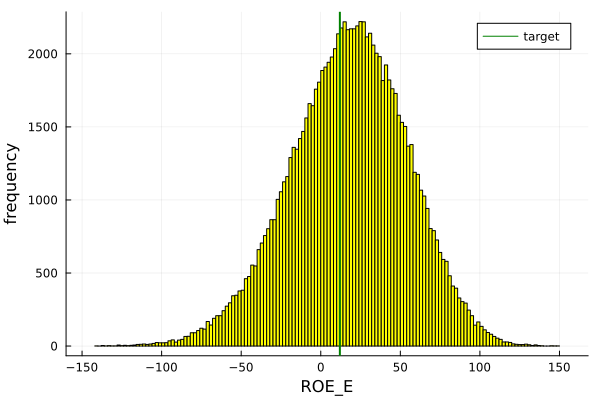

In [137]:
histogram(ROE_E, color = :yellow, label = "", xlabel = "ROE_E", ylabel = "frequency")
vline!([12], color = :green, lw = 2, label = "target")

Under the variance principle:

In [138]:
ROE_V = simulateROE("V", 100_000); # approx 13 min 

In [139]:
quantile(ROE_V, [0.025, 0.25, 0.50, 0.75, 0.975])

5-element Vector{Float64}:
 -58.340767546048944
  -6.414019839808027
  18.924945400168212
  42.77657299919378
  85.38304215382541

In [140]:
println("P(ROE_V ≥ 12%) ≈ ", mean(ROE_V .≥ 12)) 
println("P(insolvency) = P(ROE_V < -100%) ≈ ", mean(ROE_V .< -100))

P(ROE_V ≥ 12%) ≈ 0.57345
P(insolvency) = P(ROE_V < -100%) ≈ 0.00176


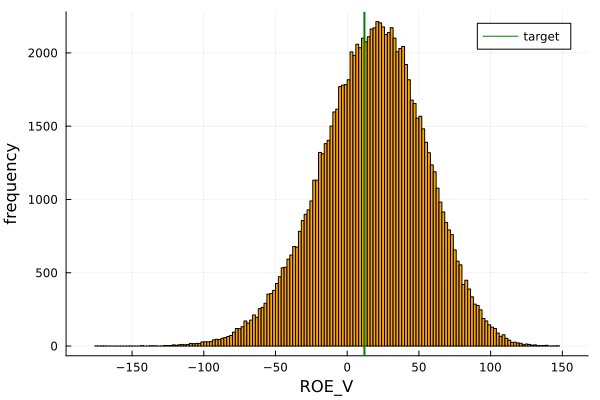

In [141]:
histogram(ROE_V, color = :orange, label = "", xlabel = "ROE_V", ylabel = "frequency")
vline!([12], color = :green, lw = 2, label = "target")

Under Exercise 2.3 formula:

In [142]:
ROE_D = simulateROE("D", 100_000); # approx 13 min 

In [143]:
quantile(ROE_D, [0.025, 0.25, 0.50, 0.75, 0.975])

5-element Vector{Float64}:
 -57.98062033809259
  -7.733969144431074
  17.43148744427686
  41.1393941784317
  82.91961507244623

In [144]:
println("P(ROE_D ≥ 12%) ≈ ", mean(ROE_D .≥ 12)) 
println("P(insolvency) = P(ROE_D < -100%) ≈ ", mean(ROE_D .< -100))

P(ROE_D ≥ 12%) ≈ 0.55913
P(insolvency) = P(ROE_D < -100%) ≈ 0.00165


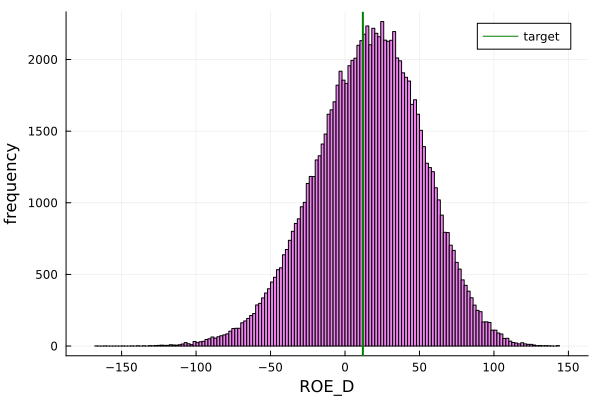

In [145]:
histogram(ROE_D, color = :violet, label = "", xlabel = "ROE_D", ylabel = "frequency")
vline!([12], color = :green, lw = 2, label = "target")